## Object splitter and measurement - Notebook version


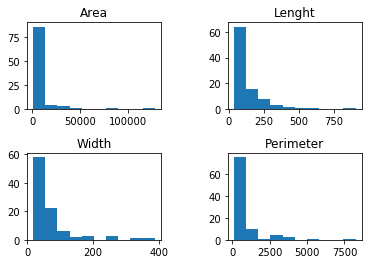

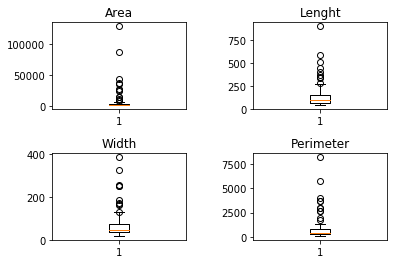

In [17]:
import time
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings

dirstr=str(round(time.time()))
os.mkdir("out_"+dirstr)
os.mkdir("out_"+dirstr+"/split")

f2 = open("out_"+dirstr+"/"+dirstr+"_ind_data.txt", 'w')
f2.write('ID,L(km),W(km),Area(km2),perimeter(km),xc,yc\n')

fname_sb='terrasp.jpg'
img = cv2.imread(fname_sb)

scale= 3   # pix/km  
tresh_8b=150  
tresh_bin=int(round(tresh_8b/100*255))#84 #84 (33%), 102 (40%) , 114 (45%)
font = cv2.FONT_HERSHEY_SIMPLEX
filtareamin=5000/(scale*scale)  # in km2
filtareamax=np.size(img)/(3)
        
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,patt = cv2.threshold(gray,tresh_8b,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(patt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contpic=cv2.imread(fname_sb)# cv2.drawContours(bwcont, contours, -1, (255, 0, 0), 1)

areatot=0
areafilt=0
nfilt=0

areafstats=[]
perfstats=[]
areastats=[]
boxc=[]
Lboxst=[]
Wboxst=[]

for j in range(0,len(contours)-1,1):
    area = cv2.contourArea(contours[j])*scale**2
    perimeter = cv2.arcLength(contours[j],True)*scale
    areatot=areatot+area
    areastats.append(area)
    if (area > filtareamin) & (area < filtareamax):
        nfilt=nfilt+1
        areafstats.append(area)
        perfstats.append(perimeter)
        areafilt=areafilt+area
        
        rect = cv2.minAreaRect(contours[j])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        boxc.append(box)
        
        x0=box[0][0]
        y0=box[0][1]
        x1=box[1][0]
        y1=box[1][1]
        x2=box[2][0]
        y2=box[2][1]
        x3=box[3][0]
        y3=box[3][1]
        
        pm0x=int(round((box[0][0]+box[1][0])/2))
        pm0y=int(round((box[0][1]+box[1][1])/2))
        pm1x=int(round((box[1][0]+box[2][0])/2))
        pm1y=int(round((box[1][1]+box[2][1])/2))
        pm2x=int(round((box[2][0]+box[3][0])/2))
        pm2y=int(round((box[2][1]+box[3][1])/2))
        pm3x=int(round((box[3][0]+box[0][0])/2))
        pm3y=int(round((box[3][1]+box[0][1])/2)) 
       
        d01box=((box[0][0]-box[1][0])**2+(box[0][1]-box[1][1])**2)**0.5
        d12box=((box[1][0]-box[2][0])**2+(box[1][1]-box[2][1])**2)**0.5
        
        Abox=d01box*d12box*scale**2
        Lbox=np.maximum(d01box,d12box)*scale
        Wbox=np.minimum(d01box,d12box)*scale    
    
        Lboxst.append(Lbox)
        Wboxst.append(Wbox)
        
        xmaxb=np.max((x0,x1,x2,x3))
        ymaxb=np.max((y0,y1,y2,y3))
        xminb=np.min((x0,x1,x2,x3))
        yminb=np.min((y0,y1,y2,y3))
        
        if(xminb < 1):
            xminb=1
        if(yminb < 1): 
            yminb=1
        if(xmaxb < 1): 
            xmaxb=1
        if(ymaxb < 1): 
            ymaxb=1
            
        #cv2.putText(contpic, str(round(area,2)), (int(round((pm0x+pm2x)*0.5)+5),int(round((pm2y+pm0y)*0.5))), font, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(contpic, str(nfilt), (int(round((pm0x+pm2x)*0.5)+5),int(round((pm2y+pm0y)*0.5))), font, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.drawContours(contpic, contours[j], -1, (255, 0, 0), 1)
        cv2.drawContours(contpic,[box],0,(0,255,255),1) 
        cv2.imwrite("out_"+dirstr+"/split/filtobj_"+str(nfilt)+".tif", contpic[yminb:ymaxb,xminb:xmaxb,:])
        f2.write(str(nfilt)+','+str(round(Lbox,2))+','+str(round(Wbox,2))+','+str(round(area,2))+','+str(round((pm0x+pm2x)*0.5,2))+','+str(round((pm2y+pm0y)*0.5,2))+'\n')

cv2.imwrite("out_"+dirstr+"/"+dirstr+"_allcont.tif", contpic)
f2.close()

# Statistical analysis plots
# create a figure 
fig = plt.figure() 
# define subplots 
plt1 = fig.add_subplot(221) 
plt2 = fig.add_subplot(222) 
plt3 = fig.add_subplot(223) 
plt4 = fig.add_subplot(224) 
plt1.hist(areafstats, bins=10) 
plt1.set_title('Area') 
plt2.hist(Lboxst, bins=10) 
plt2.set_title('Lenght') 
plt3.hist(Wboxst, bins=10)  
plt3.set_title('Width') 
plt4.hist(perfstats, bins=10) 
plt4.set_title('Perimeter') 
# Space between subplots 
fig.subplots_adjust(hspace=.5,wspace=0.5) 
plt.savefig("out_"+dirstr+"/"+dirstr+"_histplot.png",dpi=200)

# create a figure 
fig2 = plt.figure() 
# define subplots 
plt5 = fig2.add_subplot(221) 
plt6 = fig2.add_subplot(222) 
plt7 = fig2.add_subplot(223) 
plt8 = fig2.add_subplot(224) 
plt5.boxplot(areafstats) 
plt5.set_title('Area') 
plt6.boxplot(Lboxst)  
plt6.set_title('Lenght') 
plt7.boxplot(Wboxst)    
plt7.set_title('Width') 
plt8.boxplot(perfstats)  
plt8.set_title('Perimeter') 
# Space between subplots 
fig2.subplots_adjust(hspace=.5,wspace=0.5) 
plt.savefig("out_"+dirstr+"/"+dirstr+"_boxsplot.png",dpi=200)


